In [426]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [427]:
! pip install japanize_matplotlib
! pip install xfeat
! pip install category-encoders

In [428]:
## import module
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
from matplotlib_venn import venn2
import os
from statistics import mode
from scipy.optimize import minimize, minimize_scalar
from scipy.misc import derivative
import random
from imblearn.over_sampling import SMOTE, ADASYN

import missingno as msno

from IPython.display import Image

from sklearn.model_selection import KFold, StratifiedKFold
import category_encoders as ce
from xfeat import (SelectCategorical, LabelEncoder, Pipeline, ConcatCombination, SelectNumerical, 
                   ArithmeticCombinations, TargetEncoder, aggregation, GBDTFeatureSelector, GBDTFeatureExplorer)
from sklearn import preprocessing
from time import time
from contextlib import contextmanager
import lightgbm as lgb

from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import confusion_matrix

In [429]:
class CFG:
  exp = "exp15"
  seed = 71
  fold = 10

CONFIG = CFG()

In [430]:
input_dir = "/content/drive/MyDrive/KMI_ddbrothers/hirahara/data/"
output_dir = "/content/drive/MyDrive/KMI_ddbrothers/hirahara/output/"

# データフレームの形状変換

In [431]:
pd.set_option("display.max_colwidth", 300)

# Import file
df1 = pd.read_csv(input_dir + "gi_train_mm10.csv")
df2 = pd.read_csv(input_dir + "gi_train_mm11.csv")
df_test = pd.read_csv(input_dir + "gi_test.csv")
sample_submit = pd.read_csv(input_dir + "gi_sample_submit.csv")
df_train = pd.concat([df1,df2]).reset_index(drop=True)

df_train = df_train[~df_train.customer_id.isnull()].reset_index()

# 処理済みデータ読み込み

In [432]:
df_train = pd.read_pickle(input_dir + "train_rev.pkl")
df_test = pd.read_pickle(input_dir + "test_rev.pkl")

In [433]:
df_train_org = df_train.copy()

In [434]:
df_train[df_train["customer_id"]=="20201101-120054"]

,customer_id,event_day,area_id,gender,age,age_category,event_type,product_id,product_name,company,time_duration,num_touch,in_time,out_time,buy_flag,1in_3in,3in_1out
17691,20201101-120054,2020/11/1,NaN,man,30's,Young,1,NaN,NaN,NaN,28.4,NaN,2021-09-21 21:38:07.200,2021-09-21 21:38:35.600,NaN,0,28
18904,20201101-120054,2020/11/1,1.0,man,30's,Young,2,NaN,NaN,NaN,11.2,NaN,2021-09-21 21:38:15.600,2021-09-21 21:38:26.800,NaN,8,20
20272,20201101-120054,2020/11/1,NaN,man,30's,Young,3,94.0,うるうるグリーンティー525ml,エターナル,0.0,1.0,2021-09-21 21:38:20.200,NaT,0.0,13,15
20273,20201101-120054,2020/11/1,NaN,man,30's,Young,3,27.0,新緑の丘525ml,フューチャー,0.0,1.0,2021-09-21 21:38:20.800,NaT,0.0,13,14
20274,20201101-120054,2020/11/1,NaN,man,30's,Young,3,27.0,新緑の丘525ml,フューチャー,0.0,1.0,2021-09-21 21:38:21.200,NaT,1.0,14,14


In [435]:
df_train_0=df_train[df_train.event_type !=3].reset_index(drop=True)
df_test_0=df_test[df_test.event_type !=3].reset_index(drop=True)

In [436]:
df_train1 = df_train[df_train.event_type ==1].reset_index(drop=True)
df_train2 = df_train[df_train.event_type ==2].reset_index(drop=True)
df_train3 = df_train[df_train.event_type ==3].reset_index(drop=True)

df_test1 = df_test[df_test.event_type ==1].reset_index(drop=True)
df_test2 = df_test[df_test.event_type ==2].reset_index(drop=True)
df_test3 = df_test[df_test.event_type ==3].reset_index(drop=True)

## Customer_IDごとの各特徴量の整理

In [437]:
# base
df_train3 = df_train3.drop(columns=["event_type","product_id","time_duration","num_touch","in_time","out_time","area_id"])
df_test3 = df_test3.drop(columns=["event_type","product_id","time_duration","num_touch","in_time","out_time","area_id"])

#shopper frame time
df_frametime_train=df_train1[["customer_id","time_duration","in_time"]].drop_duplicates()
df_frametime_train.columns=["customer_id","time_duration_frame","in_time"]
df_frametime_test=df_test1[["customer_id","time_duration","in_time"]].drop_duplicates()
df_frametime_test.columns=["customer_id","time_duration_frame","in_time"]

# shopper area time
df_sub=df_train[df_train.event_type !=1].sort_values(["customer_id","event_type"]).reset_index(drop=True)
df_sub["time_duration"] =df_sub["time_duration"].replace(0,None) 
df_sub["area_id"]=df_sub["area_id"].fillna(method='ffill')
df_sub["time_duration"]=df_sub["time_duration"].fillna(method='ffill')
df_area_train = df_sub[~df_sub.num_touch.isnull()]
df_area_train =df_area_train.drop_duplicates()
df_area_train = df_area_train[["customer_id","area_id","time_duration"]]
df_area_train.columns=["customer_id","area_id","time_duration_area"]

df_sub=df_test[df_test.event_type !=1].sort_values(["customer_id","event_type"]).reset_index(drop=True)
df_sub["time_duration"] =df_sub["time_duration"].replace(0,None) 
df_sub["area_id"]=df_sub["area_id"].fillna(method='ffill')
df_sub["time_duration"]=df_sub["time_duration"].fillna(method='ffill')
df_area_test = df_sub[~df_sub.num_touch.isnull()]
df_area_test =df_area_test.drop_duplicates()
df_area_test = df_area_test[["customer_id","area_id","time_duration"]]
df_area_test.columns=["customer_id","area_id","time_duration_area"]

In [438]:
df_area_train

,customer_id,area_id,time_duration_area
1,20201026-010001,1.0,6.2
2,20201026-010001,1.0,6.2
4,20201026-010002,1.0,7.8
5,20201026-010002,1.0,7.8
7,20201026-010003,1.0,14.0
...,...,...,...
13475,20201101-120054,1.0,11.2
13476,20201101-120054,1.0,11.2
13477,20201101-120054,1.0,11.2
13479,20201101-120055,5.0,13.0


In [439]:
df_train = pd.merge(df_train3,df_frametime_train,on="customer_id")
df_train = pd.merge(df_train,df_area_train,on="customer_id")
df_train = df_train.reindex(columns=['customer_id', 'event_day', 'gender', 'age', 'age_category','product_name', 'company', 'area_id', '1in_3in', '3in_1out','time_duration_frame','time_duration_area', 'in_time', 'buy_flag'])
df_train = df_train.drop_duplicates()

df_test = pd.merge(df_test3,df_frametime_test,on="customer_id")
df_test = pd.merge(df_test,df_area_test,on="customer_id")
df_test = df_test.reindex(columns=['customer_id', 'event_day', 'gender', 'age', 'age_category','product_name', 'company', 'area_id', '1in_3in', '3in_1out','time_duration_frame','time_duration_area','in_time'])
df_test = df_test.drop_duplicates()

In [440]:
df_train

,customer_id,event_day,gender,age,age_category,product_name,company,area_id,1in_3in,3in_1out,time_duration_frame,time_duration_area,in_time,buy_flag
0,20201026-010001,2020/10/26,woman,30's,Young,トラディショナル緑茶525ml,クオリティー,1.0,1,5,6.2,6.2,2021-09-21 08:01:50.200,1.0
2,20201026-010001,2020/10/26,woman,30's,Young,トラディショナル緑茶525ml,クオリティー,1.0,3,2,6.2,6.2,2021-09-21 08:01:50.200,1.0
4,20201026-010002,2020/10/26,man,50's,Middle,クリアブラウン525ml,クオリティー,1.0,6,6,13.6,7.8,2021-09-21 08:02:43.600,1.0
6,20201026-010002,2020/10/26,man,50's,Middle,トラディショナル緑茶525ml,クオリティー,1.0,10,3,13.6,7.8,2021-09-21 08:02:43.600,1.0
8,20201026-010003,2020/10/26,man,50's,Middle,桃の世界410ml,フューチャー,1.0,2,11,14.2,14.0,2021-09-21 08:02:57.800,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26416,20201101-120054,2020/11/1,man,30's,Young,うるうるグリーンティー525ml,エターナル,1.0,13,15,28.4,11.2,2021-09-21 21:38:07.200,0.0
26419,20201101-120054,2020/11/1,man,30's,Young,新緑の丘525ml,フューチャー,1.0,13,14,28.4,11.2,2021-09-21 21:38:07.200,0.0
26422,20201101-120054,2020/11/1,man,30's,Young,新緑の丘525ml,フューチャー,1.0,14,14,28.4,11.2,2021-09-21 21:38:07.200,1.0
26425,20201101-120055,2020/11/1,woman,30's,Young,ジャパンスプラッシュ500ml,クオリティー,5.0,6,7,14.0,13.0,2021-09-21 21:39:27.400,0.0


In [441]:
df_test

,customer_id,event_day,gender,age,age_category,product_name,company,area_id,1in_3in,3in_1out,time_duration_frame,time_duration_area,in_time
0,20201026-010006,2020/10/26,man,40's,Middle,クリアブラウン525ml,クオリティー,1.0,8,11,19.8,7.2,2021-09-21 08:07:13.000
2,20201026-010006,2020/10/26,man,40's,Middle,クリアブラウン525ml,クオリティー,1.0,10,9,19.8,7.2,2021-09-21 08:07:13.000
4,20201026-010008,2020/10/26,man,40's,Middle,職人の力500ml,フューチャー,1.0,8,12,21.2,4.8,2021-09-21 08:10:32.600
7,20201026-010008,2020/10/26,man,40's,Middle,職人の力500ml,フューチャー,1.0,9,11,21.2,4.8,2021-09-21 08:10:32.600
10,20201026-010008,2020/10/26,man,40's,Middle,トラディショナル緑茶525ml,クオリティー,1.0,12,8,21.2,4.8,2021-09-21 08:10:32.600
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14614,20201101-120052,2020/11/1,man,20's,Young,優しい君500ml,ラボラトリー,2.0,9,19,28.6,16.8,2021-09-21 21:36:35.800
14618,20201101-120052,2020/11/1,man,20's,Young,ほっと一息500ml,エターナル,2.0,11,16,28.6,16.8,2021-09-21 21:36:35.800
14622,20201101-120052,2020/11/1,man,20's,Young,職人の力500ml,フューチャー,2.0,21,6,28.6,16.8,2021-09-21 21:36:35.800
14626,20201101-120056,2020/11/1,woman,30's,Young,匠の果実500ml,エターナル,1.0,15,7,22.6,15.2,2021-09-21 21:47:14.200


In [442]:
df_train[df_train["customer_id"]=="20201101-120054"]

,customer_id,event_day,gender,age,age_category,product_name,company,area_id,1in_3in,3in_1out,time_duration_frame,time_duration_area,in_time,buy_flag
26416,20201101-120054,2020/11/1,man,30's,Young,うるうるグリーンティー525ml,エターナル,1.0,13,15,28.4,11.2,2021-09-21 21:38:07.200,0.0
26419,20201101-120054,2020/11/1,man,30's,Young,新緑の丘525ml,フューチャー,1.0,13,14,28.4,11.2,2021-09-21 21:38:07.200,0.0
26422,20201101-120054,2020/11/1,man,30's,Young,新緑の丘525ml,フューチャー,1.0,14,14,28.4,11.2,2021-09-21 21:38:07.200,1.0


In [443]:
df_train.buy_flag.value_counts()

1.0    4976
0.0    1798
Name: buy_flag, dtype: int64

# 前処理

## 容量のカラム追加

In [444]:
size_train=df_train.product_name.str.extract(r'(\d\d\d)').astype(int)
df_train.insert(loc = 6, column= 'size', value= size_train)

size_test=df_test.product_name.str.extract(r'(\d\d\d)').astype(int)
df_test.insert(loc = 6, column= 'size', value= size_test)

In [445]:
df_train

,customer_id,event_day,gender,age,age_category,product_name,size,company,area_id,1in_3in,3in_1out,time_duration_frame,time_duration_area,in_time,buy_flag
0,20201026-010001,2020/10/26,woman,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,1,5,6.2,6.2,2021-09-21 08:01:50.200,1.0
2,20201026-010001,2020/10/26,woman,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,3,2,6.2,6.2,2021-09-21 08:01:50.200,1.0
4,20201026-010002,2020/10/26,man,50's,Middle,クリアブラウン525ml,525,クオリティー,1.0,6,6,13.6,7.8,2021-09-21 08:02:43.600,1.0
6,20201026-010002,2020/10/26,man,50's,Middle,トラディショナル緑茶525ml,525,クオリティー,1.0,10,3,13.6,7.8,2021-09-21 08:02:43.600,1.0
8,20201026-010003,2020/10/26,man,50's,Middle,桃の世界410ml,410,フューチャー,1.0,2,11,14.2,14.0,2021-09-21 08:02:57.800,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26416,20201101-120054,2020/11/1,man,30's,Young,うるうるグリーンティー525ml,525,エターナル,1.0,13,15,28.4,11.2,2021-09-21 21:38:07.200,0.0
26419,20201101-120054,2020/11/1,man,30's,Young,新緑の丘525ml,525,フューチャー,1.0,13,14,28.4,11.2,2021-09-21 21:38:07.200,0.0
26422,20201101-120054,2020/11/1,man,30's,Young,新緑の丘525ml,525,フューチャー,1.0,14,14,28.4,11.2,2021-09-21 21:38:07.200,1.0
26425,20201101-120055,2020/11/1,woman,30's,Young,ジャパンスプラッシュ500ml,500,クオリティー,5.0,6,7,14.0,13.0,2021-09-21 21:39:27.400,0.0


## 入時間の設定

In [446]:
#エントリータイムの時間を抽出
df_train["in_time"] = pd.to_datetime(df_train["in_time"])
df_train["in_time_hour"] = df_train["in_time"].apply(lambda x: x.hour)
df_train["in_time_min"] = df_train["in_time"].apply(lambda x: x.minute)
df_train=df_train.drop(columns="in_time")

df_test["in_time"] = pd.to_datetime(df_test["in_time"])
df_test["in_time_hour"] = df_test["in_time"].apply(lambda x: x.hour)
df_test["in_time_min"] = df_test["in_time"].apply(lambda x: x.minute)
df_test=df_test.drop(columns="in_time")

#曜日
df_train["event_day"] = pd.to_datetime(df_train["event_day"])
df_train["event_day"] = df_train["event_day"].apply(lambda x: x.weekday())

df_test["event_day"] = pd.to_datetime(df_test["event_day"])
df_test["event_day"] = df_test["event_day"].apply(lambda x: x.weekday())

In [447]:
df_train

,customer_id,event_day,gender,age,age_category,product_name,size,company,area_id,1in_3in,3in_1out,time_duration_frame,time_duration_area,buy_flag,in_time_hour,in_time_min
0,20201026-010001,0,woman,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,1,5,6.2,6.2,1.0,8,1
2,20201026-010001,0,woman,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,3,2,6.2,6.2,1.0,8,1
4,20201026-010002,0,man,50's,Middle,クリアブラウン525ml,525,クオリティー,1.0,6,6,13.6,7.8,1.0,8,2
6,20201026-010002,0,man,50's,Middle,トラディショナル緑茶525ml,525,クオリティー,1.0,10,3,13.6,7.8,1.0,8,2
8,20201026-010003,0,man,50's,Middle,桃の世界410ml,410,フューチャー,1.0,2,11,14.2,14.0,1.0,8,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26416,20201101-120054,6,man,30's,Young,うるうるグリーンティー525ml,525,エターナル,1.0,13,15,28.4,11.2,0.0,21,38
26419,20201101-120054,6,man,30's,Young,新緑の丘525ml,525,フューチャー,1.0,13,14,28.4,11.2,0.0,21,38
26422,20201101-120054,6,man,30's,Young,新緑の丘525ml,525,フューチャー,1.0,14,14,28.4,11.2,1.0,21,38
26425,20201101-120055,6,woman,30's,Young,ジャパンスプラッシュ500ml,500,クオリティー,5.0,6,7,14.0,13.0,0.0,21,39


In [448]:
df_test

,customer_id,event_day,gender,age,age_category,product_name,size,company,area_id,1in_3in,3in_1out,time_duration_frame,time_duration_area,in_time_hour,in_time_min
0,20201026-010006,0,man,40's,Middle,クリアブラウン525ml,525,クオリティー,1.0,8,11,19.8,7.2,8,7
2,20201026-010006,0,man,40's,Middle,クリアブラウン525ml,525,クオリティー,1.0,10,9,19.8,7.2,8,7
4,20201026-010008,0,man,40's,Middle,職人の力500ml,500,フューチャー,1.0,8,12,21.2,4.8,8,10
7,20201026-010008,0,man,40's,Middle,職人の力500ml,500,フューチャー,1.0,9,11,21.2,4.8,8,10
10,20201026-010008,0,man,40's,Middle,トラディショナル緑茶525ml,525,クオリティー,1.0,12,8,21.2,4.8,8,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14614,20201101-120052,6,man,20's,Young,優しい君500ml,500,ラボラトリー,2.0,9,19,28.6,16.8,21,36
14618,20201101-120052,6,man,20's,Young,ほっと一息500ml,500,エターナル,2.0,11,16,28.6,16.8,21,36
14622,20201101-120052,6,man,20's,Young,職人の力500ml,500,フューチャー,2.0,21,6,28.6,16.8,21,36
14626,20201101-120056,6,woman,30's,Young,匠の果実500ml,500,エターナル,1.0,15,7,22.6,15.2,21,47


## 滞在時間での切り捨て

In [449]:
df_train.groupby("buy_flag").time_duration_frame.mean()

buy_flag
0.0    89.870189
1.0    47.108842
Name: time_duration_frame, dtype: float64

In [450]:
def time_duration_revise(x,col):
  if x >= 500:
    x=df_test[col].mean()
    return x
  else:
    return x

In [451]:
#外れ値保管
df_test["1in_3in"]=df_test["1in_3in"].apply(lambda x:time_duration_revise(x,"1in_3in"))
df_test["3in_1out"]=df_test["3in_1out"].apply(lambda x:time_duration_revise(x,"3in_1out"))
df_train=df_train[df_train["3in_1out"] < 500].reset_index(drop=True)

#Frame time cut for positive
del_df_train = df_train[(df_train.time_duration_frame > 100) & (df_train.buy_flag == 1)]
others_list=set(list(df_train.index)) ^ set(list(del_df_train.index)) 
df_train = df_train.loc[others_list].reset_index(drop=True)

#Frame time cut all
df_train=df_train[df_train["time_duration_frame"] < df_test["time_duration_frame"].max()].reset_index(drop=True)
df_train=df_train[df_train["time_duration_area"] < df_test["time_duration_area"].max()].reset_index(drop=True)
df_train=df_train[df_train["1in_3in"] < df_test["1in_3in"].max()].reset_index(drop=True)
df_train=df_train[df_train["3in_1out"] < df_test["3in_1out"].max()].reset_index(drop=True)


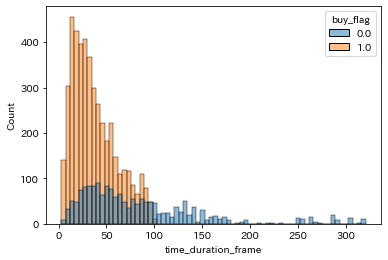

In [452]:
sns.histplot(data=df_train, x="time_duration_frame",hue="buy_flag")

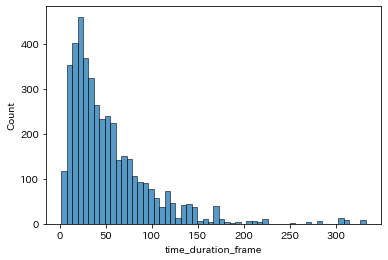

In [453]:
sns.histplot(data=df_test, x="time_duration_frame")

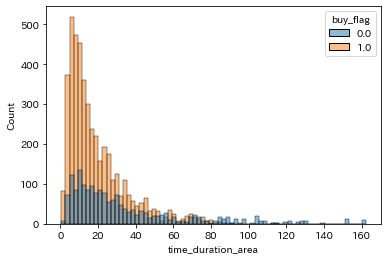

In [454]:
sns.histplot(data=df_train, x="time_duration_area",hue="buy_flag")

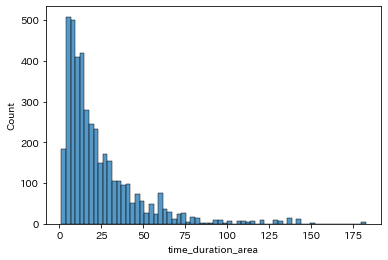

In [455]:
sns.histplot(data=df_test, x="time_duration_area")

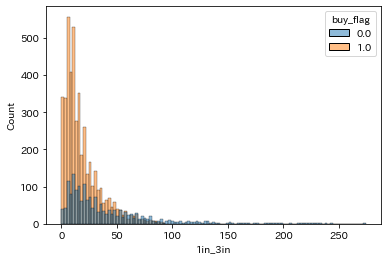

In [456]:
sns.histplot(data=df_train, x="1in_3in",hue="buy_flag")

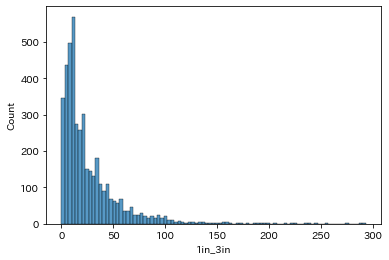

In [457]:
sns.histplot(data=df_test, x="1in_3in")

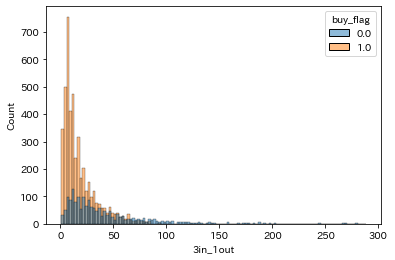

In [458]:
sns.histplot(data=df_train, x="3in_1out",hue="buy_flag")

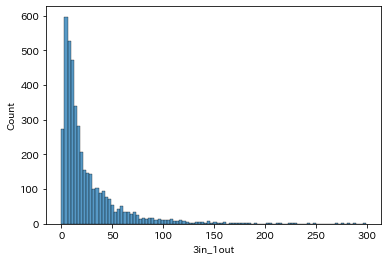

In [459]:
sns.histplot(data=df_test, x="3in_1out")

In [460]:
df_train.buy_flag.value_counts()

1.0    4571
0.0    1745
Name: buy_flag, dtype: int64

## オーバーサンプリング

In [461]:
df_train

,customer_id,event_day,gender,age,age_category,product_name,size,company,area_id,1in_3in,3in_1out,time_duration_frame,time_duration_area,buy_flag,in_time_hour,in_time_min
0,20201026-010001,0,woman,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,1,5,6.2,6.2,1.0,8,1
1,20201026-010001,0,woman,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,3,2,6.2,6.2,1.0,8,1
2,20201026-010002,0,man,50's,Middle,クリアブラウン525ml,525,クオリティー,1.0,6,6,13.6,7.8,1.0,8,2
3,20201026-010002,0,man,50's,Middle,トラディショナル緑茶525ml,525,クオリティー,1.0,10,3,13.6,7.8,1.0,8,2
4,20201026-010003,0,man,50's,Middle,桃の世界410ml,410,フューチャー,1.0,2,11,14.2,14.0,1.0,8,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6311,20201101-120054,6,man,30's,Young,うるうるグリーンティー525ml,525,エターナル,1.0,13,15,28.4,11.2,0.0,21,38
6312,20201101-120054,6,man,30's,Young,新緑の丘525ml,525,フューチャー,1.0,13,14,28.4,11.2,0.0,21,38
6313,20201101-120054,6,man,30's,Young,新緑の丘525ml,525,フューチャー,1.0,14,14,28.4,11.2,1.0,21,38
6314,20201101-120055,6,woman,30's,Young,ジャパンスプラッシュ500ml,500,クオリティー,5.0,6,7,14.0,13.0,0.0,21,39


In [462]:
adasyn = ADASYN(random_state = CONFIG.seed)
#sample_cols=["1in_3in", "3in_1out","time_duration_frame","time_duration_area","in_time_hour","in_time_min"]
sample_cols=["time_duration_frame","time_duration_area","in_time_hour","in_time_min"]

#対象カラムのオーバーサンプリング
X, y = adasyn.fit_resample(df_train[sample_cols], df_train['buy_flag'])
df_oversample = pd.DataFrame(X, columns = sample_cols)
df_oversample["buy_flag"]=y
add_samples=df_oversample.iloc[list(df_train.index)[-1]+1:]

#buy_flag=0のrow複製
add_nums = len(df_oversample)-len(df_train) 
sample_list = list(df_train[df_train.buy_flag==0].index)
over_items =random.choices(sample_list,k=add_nums)
add_df = df_train.loc[over_items]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



In [463]:
#オーバサンプリングした数値の上書き
add_nums = len(df_oversample)-len(df_train) 
sample_list = list(df_train[df_train.buy_flag==0].index)
over_items =random.choices(sample_list,k=add_nums)
add_df = df_train.loc[over_items]

In [464]:
for i in sample_cols:
  add_df[i]=add_samples[i].values

In [465]:
add_df

,customer_id,event_day,gender,age,age_category,product_name,size,company,area_id,1in_3in,3in_1out,time_duration_frame,time_duration_area,buy_flag,in_time_hour,in_time_min
4722,20201031-050116,5,man,30's,Young,スッキリピーチ水555ml,555,フューチャー,2.0,80,168,58.379862,29.040276,0.0,8.704831,19.302070
3687,20201030-040143,4,man,50's,Middle,朝の雫540ml,540,ラボラトリー,1.0,7,73,58.257416,29.285167,0.0,12.990423,21.138753
1570,20201027-060139,1,woman,50's,Middle,スペシャルライフ500ml,500,フューチャー,3.0,35,42,58.400000,29.000000,0.0,8.000000,19.000000
6307,20201101-120053,6,man,30's,Young,伝統の技525ml,525,イッツ園,1.0,32,9,58.400000,29.000000,0.0,8.000000,19.000000
1216,20201027-030205,1,woman,30's,Young,しゅわしゅわオレンジ420ml,420,ラボラトリー,3.0,13,159,58.341478,29.117044,0.0,10.048264,19.877827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799,20201027-010009,1,man,40's,Middle,シルクの風490ml,490,ネイティブ,4.0,3,5,29.068640,11.200000,0.0,18.492600,38.417900
3576,20201030-030169,4,woman,50's,Middle,しゅわしゅわオレンジ420ml,420,ラボラトリー,3.0,21,17,28.400000,11.200000,0.0,21.000000,38.000000
3369,20201030-020034,4,woman,40's,Middle,カフェインレス健康茶630ml,630,ネイティブ,1.0,26,18,17.940658,12.641758,0.0,17.417584,38.104396
2270,20201028-060125,2,man,40's,Middle,水玉ウォーター500ml,500,カルシウムウェイ,4.0,116,42,17.870874,13.351898,0.0,16.601279,38.120256


In [466]:
df_train = pd.concat([df_train,add_df],axis=0).reset_index(drop=True)

In [467]:
df_train.buy_flag.value_counts()

1.0    4571
0.0    4479
Name: buy_flag, dtype: int64

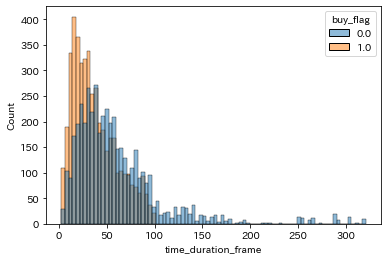

In [468]:
sns.histplot(data=df_train, x="time_duration_frame",hue="buy_flag")

In [469]:
df_train

,customer_id,event_day,gender,age,age_category,product_name,size,company,area_id,1in_3in,3in_1out,time_duration_frame,time_duration_area,buy_flag,in_time_hour,in_time_min
0,20201026-010001,0,woman,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,1,5,6.200000,6.200000,1.0,8.000000,1.000000
1,20201026-010001,0,woman,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,3,2,6.200000,6.200000,1.0,8.000000,1.000000
2,20201026-010002,0,man,50's,Middle,クリアブラウン525ml,525,クオリティー,1.0,6,6,13.600000,7.800000,1.0,8.000000,2.000000
3,20201026-010002,0,man,50's,Middle,トラディショナル緑茶525ml,525,クオリティー,1.0,10,3,13.600000,7.800000,1.0,8.000000,2.000000
4,20201026-010003,0,man,50's,Middle,桃の世界410ml,410,フューチャー,1.0,2,11,14.200000,14.000000,1.0,8.000000,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9045,20201027-010009,1,man,40's,Middle,シルクの風490ml,490,ネイティブ,4.0,3,5,29.068640,11.200000,0.0,18.492600,38.417900
9046,20201030-030169,4,woman,50's,Middle,しゅわしゅわオレンジ420ml,420,ラボラトリー,3.0,21,17,28.400000,11.200000,0.0,21.000000,38.000000
9047,20201030-020034,4,woman,40's,Middle,カフェインレス健康茶630ml,630,ネイティブ,1.0,26,18,17.940658,12.641758,0.0,17.417584,38.104396
9048,20201028-060125,2,man,40's,Middle,水玉ウォーター500ml,500,カルシウムウェイ,4.0,116,42,17.870874,13.351898,0.0,16.601279,38.120256


## Area外滞在時間/Area滞在時間率

In [470]:
df_train["time_frameout"] = df_train["time_duration_frame"] - df_train["time_duration_area"]
df_test["time_frameout"] = df_test["time_duration_frame"] - df_test["time_duration_area"]

In [471]:
df_train["time_area_rate"] = df_train["time_duration_area"] / df_train["time_duration_frame"]
df_test["time_area_rate"] = df_test["time_duration_area"] / df_test["time_duration_frame"]

In [472]:
df_train

,customer_id,event_day,gender,age,age_category,product_name,size,company,area_id,1in_3in,3in_1out,time_duration_frame,time_duration_area,buy_flag,in_time_hour,in_time_min,time_frameout,time_area_rate
0,20201026-010001,0,woman,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,1,5,6.200000,6.200000,1.0,8.000000,1.000000,0.000000,1.000000
1,20201026-010001,0,woman,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,3,2,6.200000,6.200000,1.0,8.000000,1.000000,0.000000,1.000000
2,20201026-010002,0,man,50's,Middle,クリアブラウン525ml,525,クオリティー,1.0,6,6,13.600000,7.800000,1.0,8.000000,2.000000,5.800000,0.573529
3,20201026-010002,0,man,50's,Middle,トラディショナル緑茶525ml,525,クオリティー,1.0,10,3,13.600000,7.800000,1.0,8.000000,2.000000,5.800000,0.573529
4,20201026-010003,0,man,50's,Middle,桃の世界410ml,410,フューチャー,1.0,2,11,14.200000,14.000000,1.0,8.000000,2.000000,0.200000,0.985915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9045,20201027-010009,1,man,40's,Middle,シルクの風490ml,490,ネイティブ,4.0,3,5,29.068640,11.200000,0.0,18.492600,38.417900,17.868640,0.385295
9046,20201030-030169,4,woman,50's,Middle,しゅわしゅわオレンジ420ml,420,ラボラトリー,3.0,21,17,28.400000,11.200000,0.0,21.000000,38.000000,17.200000,0.394366
9047,20201030-020034,4,woman,40's,Middle,カフェインレス健康茶630ml,630,ネイティブ,1.0,26,18,17.940658,12.641758,0.0,17.417584,38.104396,5.298899,0.704643
9048,20201028-060125,2,man,40's,Middle,水玉ウォーター500ml,500,カルシウムウェイ,4.0,116,42,17.870874,13.351898,0.0,16.601279,38.120256,4.518976,0.747132


## ターゲットエンコーディング（購入率）

In [473]:
def target_encoding(df,df_1,col):

  rate_df=df_train.groupby(col).buy_flag.sum().reset_index().set_index(col)
  count_df=df_train.groupby(col).customer_id.count().reset_index().set_index(col)

  cvr_df=pd.concat([rate_df,count_df],axis=1)
  cvr_df["cvr_rate_"+str(col)]=cvr_df["buy_flag"] / cvr_df["customer_id"]
  cvr_df=cvr_df.drop(columns=["buy_flag","customer_id"])
  cvr_df=cvr_df.reset_index()

  df = pd.merge(df,cvr_df,on=col)
  df_1 = pd.merge(df_1,cvr_df,on=col)

  return df,df_1

In [474]:
target_cols=['event_day',
             'gender', 
             'age',
             'age_category',
             'product_name', 
             'size',
             'company',
             'area_id',
             'in_time_hour']

for col in target_cols:
  df_train,df_test=target_encoding(df_train,df_test,col)

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:1127: UserWarning:

You are merging on int and float columns where the float values are not equal to their int representation



In [475]:
df_train

,customer_id,event_day,gender,age,age_category,product_name,size,company,area_id,1in_3in,3in_1out,time_duration_frame,time_duration_area,buy_flag,in_time_hour,in_time_min,time_frameout,time_area_rate,cvr_rate_event_day,cvr_rate_gender,cvr_rate_age,cvr_rate_age_category,cvr_rate_product_name,cvr_rate_size,cvr_rate_company,cvr_rate_area_id,cvr_rate_in_time_hour
0,20201026-010001,0,woman,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,1,5,6.200000,6.200000,1.0,8.000000,1.000000,0.000000,1.000000,0.545704,0.493394,0.569733,0.578388,0.722973,0.555043,0.652381,0.529924,0.668605
1,20201026-010001,0,woman,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,3,2,6.200000,6.200000,1.0,8.000000,1.000000,0.000000,1.000000,0.545704,0.493394,0.569733,0.578388,0.722973,0.555043,0.652381,0.529924,0.668605
2,20201027-010002,1,woman,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,17,2,19.400000,8.200000,1.0,8.000000,2.000000,11.200000,0.422680,0.461658,0.493394,0.569733,0.578388,0.722973,0.555043,0.652381,0.529924,0.668605
3,20201027-010049,1,woman,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,12,30,43.000000,7.800000,1.0,8.000000,43.000000,35.200000,0.181395,0.461658,0.493394,0.569733,0.578388,0.722973,0.555043,0.652381,0.529924,0.668605
4,20201026-010050,0,man,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,16,7,23.800000,12.200000,1.0,8.000000,50.000000,11.600000,0.512605,0.545704,0.518545,0.569733,0.578388,0.722973,0.555043,0.652381,0.529924,0.668605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9045,20201030-060198,4,woman,60's,Senior,ハードコア120ml,120,トップモード,2.0,32,45,88.706080,77.236185,0.0,17.429560,37.570440,11.469895,0.870698,0.526144,0.493394,0.506826,0.511580,0.145833,0.145833,0.392405,0.470687,0.000000
9046,20201030-060198,4,woman,60's,Senior,ハードコア120ml,120,トップモード,2.0,68,9,89.959799,26.339698,0.0,18.016751,17.949748,63.620101,0.292794,0.526144,0.493394,0.506826,0.511580,0.145833,0.145833,0.392405,0.470687,0.000000
9047,20201030-070211,4,man,30's,Young,あの日のソーダ500ml,500,レモン王,2.0,11,18,27.257042,21.563508,0.0,18.311780,46.311780,5.693534,0.791117,0.526144,0.518545,0.569733,0.578388,0.491803,0.524529,0.487654,0.470687,0.000000
9048,20201029-040157,3,man,10's,Teen,ミックスフルーツドリンク500ml,500,大自然カンパニー,2.0,21,269,84.479096,75.603051,0.0,11.380226,15.619774,8.876045,0.894932,0.537489,0.518545,0.223518,0.223518,0.253968,0.524529,0.253968,0.470687,0.000000


In [476]:
df_test

,customer_id,event_day,gender,age,age_category,product_name,size,company,area_id,1in_3in,3in_1out,time_duration_frame,time_duration_area,in_time_hour,in_time_min,time_frameout,time_area_rate,cvr_rate_event_day,cvr_rate_gender,cvr_rate_age,cvr_rate_age_category,cvr_rate_product_name,cvr_rate_size,cvr_rate_company,cvr_rate_area_id,cvr_rate_in_time_hour
0,20201026-010006,0,man,40's,Middle,クリアブラウン525ml,525,クオリティー,1.0,8.0,11.0,19.8,7.2,8,7,12.6,0.363636,0.545704,0.518545,0.510989,0.556363,0.818966,0.555043,0.652381,0.529924,0.668605
1,20201026-010006,0,man,40's,Middle,クリアブラウン525ml,525,クオリティー,1.0,10.0,9.0,19.8,7.2,8,7,12.6,0.363636,0.545704,0.518545,0.510989,0.556363,0.818966,0.555043,0.652381,0.529924,0.668605
2,20201029-010002,3,man,40's,Middle,クリアブラウン525ml,525,クオリティー,1.0,10.0,4.0,14.4,5.2,8,1,9.2,0.361111,0.537489,0.518545,0.510989,0.556363,0.818966,0.555043,0.652381,0.529924,0.668605
3,20201030-010007,4,man,40's,Middle,クリアブラウン525ml,525,クオリティー,1.0,8.0,10.0,18.4,7.2,8,7,11.2,0.391304,0.526144,0.518545,0.510989,0.556363,0.818966,0.555043,0.652381,0.529924,0.668605
4,20201030-010007,4,man,40's,Middle,クリアブラウン525ml,525,クオリティー,1.0,10.0,8.0,18.4,7.2,8,7,11.2,0.391304,0.526144,0.518545,0.510989,0.556363,0.818966,0.555043,0.652381,0.529924,0.668605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4289,20201101-050032,6,woman,40's,Middle,黒の息吹500ml,500,モーリーフラフト,2.0,51.0,13.0,64.8,37.8,13,13,27.0,0.583333,0.517981,0.493394,0.510989,0.556363,0.464912,0.524529,0.325397,0.470687,0.710970
4290,20201101-050032,6,woman,40's,Middle,ミルクマシマシラテ450ml,450,モーリーフラフト,2.0,44.0,20.0,64.8,37.8,13,13,27.0,0.583333,0.517981,0.493394,0.510989,0.556363,0.210145,0.279621,0.325397,0.470687,0.710970
4291,20201029-030110,3,woman,30's,Young,ミルクマシマシラテ450ml,450,モーリーフラフト,2.0,36.0,13.0,50.0,35.8,13,59,14.2,0.716000,0.537489,0.493394,0.569733,0.578388,0.210145,0.279621,0.325397,0.470687,0.710970
4292,20201031-030018,5,woman,30's,Young,ミルクマシマシラテ450ml,450,モーリーフラフト,2.0,14.0,11.0,25.8,10.8,13,5,15.0,0.418605,0.439974,0.493394,0.569733,0.578388,0.210145,0.279621,0.325397,0.470687,0.710970


## カテゴリーのエンコーディング

In [477]:
# BaseBlock
class BaseBlock(object):
    def fit(self, input_df, y=None):
        return self.transform(input_df)
    
    def transform(self, input_df):
        raise NotImplementedError()
        
# CountEncoding
class CountEncodingBlock(BaseBlock):
    def __init__(self, cols):
        self.cols = cols
        self.encoder = None
        
    def fit(self, input_df, y=None):
        return self.transform(input_df[self.cols])
    
    def transform(self, input_df):
        self.encoder = ce.CountEncoder()
        self.encoder.fit(input_df[self.cols])
        return self.encoder.transform(input_df[self.cols]).add_prefix("CE_")

# OneHotEncoding
class OneHotEncodingBlock(BaseBlock):
    def __init__(self, cols):
        self.cols = cols
        self.encoder = None
        
    def fit(self, input_df, y=None):
        self.encoder = ce.OneHotEncoder(use_cat_names=True)
        self.encoder.fit(input_df[self.cols])
        return self.transform(input_df[self.cols])
    
    def transform(self, input_df):
        return self.encoder.transform(input_df[self.cols]).add_prefix("OHE_")

# OrdinalEncoding
class OrdinalEncodingBlock(BaseBlock):
    def __init__(self, cols):
        self.cols = cols
        self.encoder = None
        
    def fit(self, input_df, y=None):
        self.encoder = ce.OrdinalEncoder()
        self.encoder.fit(input_df[self.cols])
        return self.transform(input_df[self.cols])
    
    def transform(self, input_df):
        return self.encoder.transform(input_df[self.cols]).add_prefix("OE_")

In [478]:
def get_ce_features(input_df):
    _input_df = pd.concat([input_df], axis=1)
    
    cols = ['gender',
            'age',
            'age_category', 
            'event_day', 
            'area_id',
            'in_time_hour',
            'in_time_min',
            'product_name', 
            'size', 
            'company']
    encoder = CountEncodingBlock(cols = cols)
    output_df = encoder.fit(_input_df.astype(str))
    return output_df


def get_oe_features(input_df):
    _input_df = pd.concat([input_df], axis=1)
    cols = ['gender',
            'age',
            'age_category', 
            'event_day', 
            'area_id',
            'in_time_hour',
            'in_time_min',
            'product_name', 
            'size', 
            'company']
    encoder = OrdinalEncodingBlock(cols = cols)
    output_df = encoder.fit(_input_df)
    return output_df

# not use
def get_ohe_features(input_df):
    _input_df = pd.concat([input_df], axis=1)
    cols = ['gender',
            'age',
            'age_category', 
            'event_day', 
            'area_id',
            'in_time_hour',
            'in_time_min',
            'product_name', 
            'size', 
            'company']
    encoder = OneHotEncodingBlock(cols=cols)
    output_df = encoder.fit(_input_df)
    return output_df

In [479]:
df_train_ce=get_ce_features(df_train)
df_train_oe=get_oe_features(df_train)

df_test_ce=get_ce_features(df_test)
df_test_oe=get_oe_features(df_test)

In [480]:
target = df_train["buy_flag"]
df_train_encoded = df_train.drop(columns=['gender','age','age_category', 'event_day', 'area_id','in_time_hour','in_time_min','product_name', 'size', 'company',"buy_flag"])
df_train_encoded = pd.concat([df_train_encoded,df_train_ce,df_train_oe],axis=1)
df_train_encoded["buy_flag"] = target 

df_test_encoded = df_test.drop(columns=['gender','age','age_category', 'event_day', 'area_id','in_time_hour','in_time_min','product_name', 'size', 'company'])
df_test_encoded = pd.concat([df_test_encoded,df_test_ce,df_test_oe],axis=1)

# モデル作成　(Light GBM)

In [481]:
@contextmanager
def timer(logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None):
    if prefix: format_str = str(prefix) + format_str
    if suffix: format_str = format_str + str(suffix)
    start = time()
    yield
    d = time() - start
    out_str = format_str.format(d)
    if logger:
        logger.info(out_str)
    else:
        print(out_str)

In [482]:
def fit_lgbm(X, y, cv, params: dict=None, verbose: int=50):
    
    metric_func = roc_auc_score
    
    if params is None:
        params = {}

    models = []
    
    # training data の target と同じだけのゼロ配列を用意
    #oof_pred_df = pd.DataFrame(np.zeros_like(train_y, dtype=np.float)).rename(columns={0:"pred"})
    oof_pred_df = pd.DataFrame()

    for i, (idx_train, idx_valid) in enumerate(cv): 
        # 交差検証 データセットを cv instance によって分割
        # training data を trian/valid に分割
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgb.LGBMClassifier(**params)

        # auc_score用のborder算出(単純にデータ数で閾値を決定）
        #border = y_valid.sum() / len(x_valid)

        #print(f"Best_Score_Border： {border}")

        with timer(prefix='fit fold={} '.format(i + 1)):
            clf.fit(x_train, y_train, 
                    eval_set=[(x_valid, y_valid)],  
                    early_stopping_rounds=verbose,
                    verbose=verbose)
        
        # border で1, 0を分離するので、確率で算出する

        pred_i = clf.predict_proba(x_valid)[:, 1]
        pred_b = clf.predict(x_valid)

        #pred_i = np.where(pred_i < border, 0, 1)
        print(f'AUC {i} Score: {metric_func(y_valid, pred_i) :.4f}')
        
        oof_fold_df = pd.DataFrame(np.zeros_like(y_valid, dtype=np.float)).rename(columns={0:"pred"})
        oof_fold_df["id"]=idx_valid
        oof_fold_df["fold"]=i+1
        oof_fold_df["pred_prob"] = pred_i
        oof_fold_df["pred_bool"] = pred_b
        
        oof_pred_df=pd.concat([oof_pred_df,oof_fold_df],axis=0)
        
        
        models.append(clf)
        
    oof_pred_df=oof_pred_df.sort_values("id").reset_index(drop=True).set_index("id").reindex(['fold', 'y', 'pred_prob','pred_bool'], axis='columns')
    oof_pred_df["y"]=y
    score = metric_func(y, oof_pred_df["pred_prob"]) 
    print('FINISHED | AUC Score: {:.4f}'.format(score))
    return oof_pred_df, models

## 学習

In [483]:
params = {
    'learning_rate': 0.01,
    'n_estimators': 10000,
    'objective': "binary",
    'class_weight':"balanced",
    'max_depth': 10,
    #"early_stopping_rounds": 100,
    "random_state":71
    }

fold = StratifiedKFold(n_splits=CONFIG.fold, shuffle=True, random_state=CONFIG.seed)
cv = list(fold.split(df_train_encoded, df_train_encoded["buy_flag"]))

train_x=df_train_encoded.drop(columns=["customer_id"])
train_x = train_x.iloc[:,:-1]
train_y = df_train_encoded["buy_flag"]


oof, models = fit_lgbm(train_x.values, train_y, cv, params=params)

Training until validation scores don't improve for 50 rounds.
[50]	valid_0's binary_logloss: 0.508998
[100]	valid_0's binary_logloss: 0.421059
[150]	valid_0's binary_logloss: 0.374294
[200]	valid_0's binary_logloss: 0.348051
[250]	valid_0's binary_logloss: 0.33277
[300]	valid_0's binary_logloss: 0.325423
[350]	valid_0's binary_logloss: 0.320172
[400]	valid_0's binary_logloss: 0.316766
[450]	valid_0's binary_logloss: 0.314736
[500]	valid_0's binary_logloss: 0.313334
[550]	valid_0's binary_logloss: 0.312027
[600]	valid_0's binary_logloss: 0.310427
[650]	valid_0's binary_logloss: 0.308836
[700]	valid_0's binary_logloss: 0.308058
[750]	valid_0's binary_logloss: 0.306742
[800]	valid_0's binary_logloss: 0.305627
[850]	valid_0's binary_logloss: 0.304773
[900]	valid_0's binary_logloss: 0.30426
[950]	valid_0's binary_logloss: 0.303972
[1000]	valid_0's binary_logloss: 0.303372
[1050]	valid_0's binary_logloss: 0.303246
[1100]	valid_0's binary_logloss: 0.302511
[1150]	valid_0's binary_logloss: 0.3

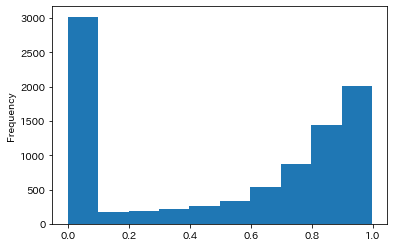

In [484]:
oof["pred_prob"].plot(kind="hist")

In [485]:
df_train_encoded[["customer_id"]]

,customer_id
0,20201026-010001
1,20201026-010001
2,20201027-010002
3,20201027-010049
4,20201026-010050
...,...
9045,20201030-060198
9046,20201030-060198
9047,20201030-070211
9048,20201029-040157


In [486]:
train_pred_1=pd.concat([oof[["pred_prob","y"]],df_train_encoded[["customer_id"]]],axis=1).set_index("customer_id")

In [487]:
a=df_train_org[df_train_org.event_type!=3].customer_id.unique()
b=df_train_org[df_train_org.event_type==3].customer_id.unique()
others_list=list(set(list(a)) ^ set(list(b)) )

train_pred_0 = pd.DataFrame()
train_pred_0["customer_id"] = others_list
train_pred_0["pred_prob"] = 0
train_pred_0["y"] = 0
train_pred_0=train_pred_0.set_index("customer_id")
train_pred=pd.concat([train_pred_1,train_pred_0],axis=0).reset_index().sort_values("customer_id").reset_index(drop=True)

In [488]:
score = roc_auc_score(train_pred["y"], train_pred["pred_prob"]) 
print('Train | AUC Score: {:.4f}'.format(score))

Train | AUC Score: 0.9636


## 学習結果

In [489]:
#特徴量の可視化
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現する.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], 
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(10, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df, 
                  x='feature_importance', 
                  y='column', 
                  order=order, 
                  ax=ax, 
                  palette='Blues_d', 
                  orient='h')
    ax.tick_params(axis='x', rotation=90)
    ax.set_title('Importance')
    ax.grid()
    fig.tight_layout()
    
    return fig, ax

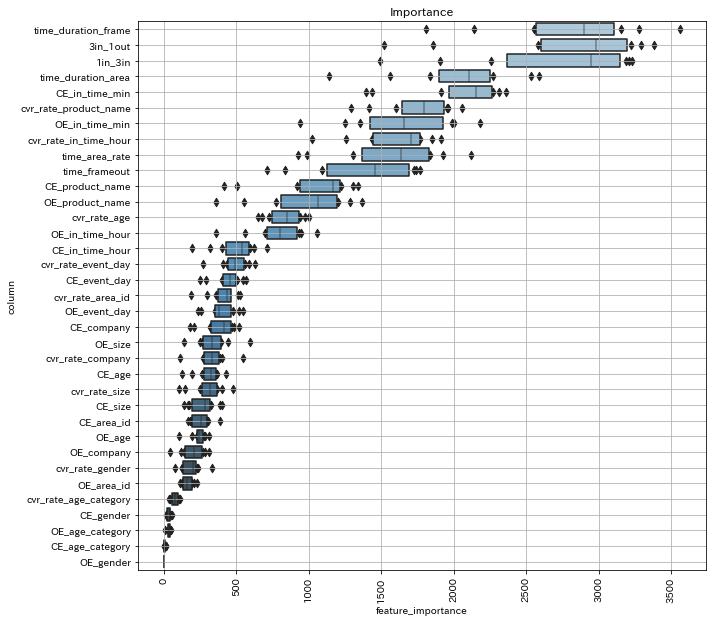

In [490]:
fig, ax = visualize_importance(models, train_x)

In [491]:
#ROCカーブの可視化
def visulalize_roc(df, fold):
    """各foldおよび出力平均のROCカーブを描画する

    args:
        df:出力oof df
        fold: fold数
    """
    
    fig = plt.figure(figsize=[8,8])
    
    tprs = []
    aucs = []
    
    mean_fpr = np.linspace(0,1,100)
    
    i = 1
    
    folds = list(range(1,fold+1))
    

    for v in folds:
        
        df_tmp = df[df.fold==v]
        fpr, tpr, t = roc_curve(df_tmp["y"], df_tmp["pred_prob"])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.3f)' % (i, roc_auc))
        i= i+1

    plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, color='blue',
             label=r'Mean ROC (AUC = %0.3f )' % (mean_auc),lw=2, alpha=1)

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")

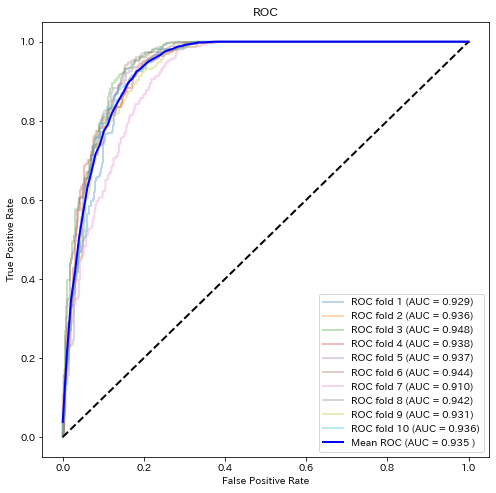

In [492]:
visulalize_roc(oof,CONFIG.fold)

In [493]:
#混合行列の可視化
def visualize_confusion_matrix(y_true,pred_label,height=.6,labels=None):
    
    """
    混合行列をプロットする
    """
    
    conf = confusion_matrix(y_true=y_true,
                            y_pred=pred_label,
                            normalize='true')

    n_labels = len(conf)
    size = n_labels * height
    fig, ax = plt.subplots(figsize=(size * 4, size * 3))
    sns.heatmap(conf, cmap='Blues', ax=ax, annot=True, fmt='.2f')
    ax.set_ylabel('Label')
    ax.set_xlabel('Predict')

    if labels is not None:
        ax.set_yticklabels(labels)
        ax.set_xticklabels(labels)
        ax.tick_params('y', labelrotation=0)
        ax.tick_params('x', labelrotation=90)

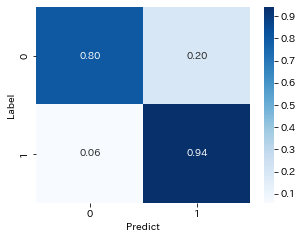

In [494]:
visualize_confusion_matrix(y_true=oof.y,pred_label=oof.pred_bool)

## 予測

In [495]:
df_index = df_test_encoded["customer_id"]
df_test_pred = df_test_encoded.iloc[:,1:]

pred = np.array([model.predict_proba(df_test_pred.values) for model in models])
pred = np.mean(pred, axis=0)[:, 1]
#pred = np.where(pred < 0.5, 0, 1)

In [496]:
submission_pred = pd.DataFrame()
submission_pred["customer_id"] = df_index
submission_pred["buy_proba"] = pred

In [497]:
submission_pred = submission_pred.groupby("customer_id").max()

In [498]:
submission_pred

,buy_proba
customer_id,
20201026-010006,0.950420
20201026-010008,0.897812
20201026-010011,0.935157
20201026-010012,0.937020
20201026-010018,0.606088
...,...
20201101-120031,0.951086
20201101-120033,0.888780
20201101-120051,0.920438


In [499]:
#submission_pred=submission_pred.groupby("customer_id").mean().reset_index()
#pred = np.where( submission_pred["buy_proba"].values<0.5, 0, 1)
#submission_pred["buy_proba"]=pred
#submission_pred=submission_pred.set_index("customer_id")

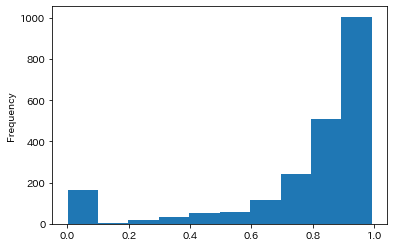

In [500]:
submission_pred["buy_proba"].plot(kind="hist")

In [501]:
submission_pred_0 = pd.DataFrame()
submission_pred_0["customer_id"] = df_test_0["customer_id"]
submission_pred_0["buy_proba"] = 0
submission_pred_0 = submission_pred_0.drop_duplicates()
submission_pred_0=submission_pred_0.set_index("customer_id")

others_list=set(list(submission_pred.index)) ^ set(list(submission_pred_0.index)) 
submission_pred_0 = submission_pred_0.loc[others_list]

In [502]:
submission_pred_0

,buy_proba
customer_id,
20201031-080220,0
20201031-020213,0
20201026-040004,0
20201027-050025,0
20201031-030036,0
...,...
20201027-030097,0
20201031-050038,0
20201026-060229,0


In [503]:
submission_pred_all = pd.concat([submission_pred,submission_pred_0],axis=0).reset_index().sort_values("customer_id").reset_index(drop=True)

In [504]:
submission_pred_all

,customer_id,buy_proba
0,20201026-010006,0.950420
1,20201026-010008,0.897812
2,20201026-010011,0.935157
3,20201026-010012,0.937020
4,20201026-010018,0.606088
...,...,...
4525,20201101-120039,0.000000
4526,20201101-120046,0.000000
4527,20201101-120051,0.920438
4528,20201101-120052,0.880606


In [505]:
submission_pred_all.buy_proba.value_counts()

0.000000    2326
0.441148       1
0.888922       1
0.931173       1
0.954504       1
            ... 
0.698383       1
0.940487       1
0.971913       1
0.930740       1
0.969383       1
Name: buy_proba, Length: 2205, dtype: int64

In [506]:
submission_pred_all.to_csv(output_dir + CONFIG.exp+ "_submission.csv",index=False)